In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

# make the data
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

np.random.seed(42)
N = 101
b0_true = 10
A_true = 3
sigma_true = 3.0
T_true = 40
err0_y = 0.5

t = np.sort(100 * np.random.random(N))
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
y_obs = np.random.normal(y_true, err_y)

Text(0,0.5,'y$_{\\rm obs}$')

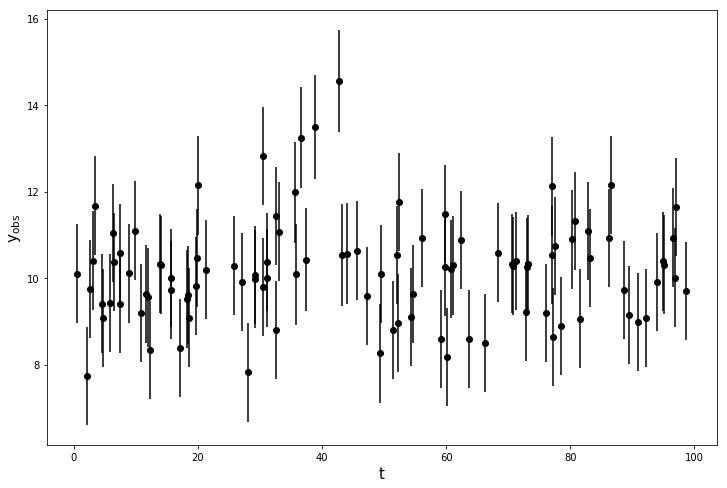

In [2]:
fig = pl.figure(figsize=(12, 8))
pl.errorbar(t, y_obs, yerr=err_y, fmt='o', color='k')
pl.xlabel('t', size=15)
pl.ylabel(r'y$_{\rm obs}$', size=15)

Gaussian fit
------------
best fit mu:	 40.169545795996406
best fit sigma:	 2.6788854147721035

Decaying Exponential Fit
-------------
best fit t0:	 36.257409014554675
best fit alpha:	 3.1107233414271356


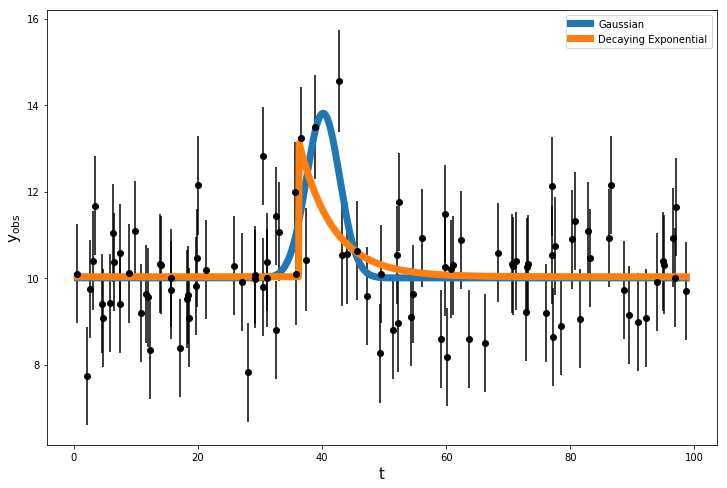

In [3]:
# fit the data with a gaussian
from scipy.optimize import minimize

# gaussian model
def gauss(t, background, A, sigma, mu):
    return background + A*np.exp(-0.5*((t - mu)**2.)/(sigma**2))

# decaying exponential model
def exp_decay(t, background, A, alpha, t0):
    mask = (t > t0)
    return background + A*mask*np.nan_to_num(np.exp(-alpha*(t - t0)))

# negative log likelihood computation
def neg_log_like(model, data, err):
    return np.sum(0.5*((model-data)**2)/(err**2) + np.log((np.sqrt(2*np.pi)*err)))

# lambda function to define negative log lokelihood for each model 
lnL_gauss = lambda params: neg_log_like(gauss(t, *params), y_obs, err_y)
lnL_exp = lambda params: neg_log_like(exp_decay(t, *params), y_obs, err_y)

# find parameters to minimize each model 
min_params_gauss = minimize(lnL_gauss, x0=[10, 10, 10, 40])
min_params_exp = minimize(lnL_exp, x0=[10, 4, 0.1, 40], method='Nelder-Mead')

# plot against the data
pl.figure(figsize=(12, 8))
tp = np.linspace(t.min(), t.max(), 1000)
pl.plot(tp, gauss(tp, *min_params_gauss.x), '-', linewidth=7, label='Gaussian')
pl.plot(tp, exp_decay(tp, *min_params_exp.x), '-', linewidth=7, label='Decaying Exponential')
pl.errorbar(t, y_obs, fmt='o', yerr=err_y, color='k')
pl.xlabel('t', size=15)
pl.ylabel(r'y$_{\rm obs}$', size=15)
pl.legend()

# print best fit parameters
print('Gaussian fit')
print('------------')
print('best fit mu:\t', min_params_gauss.x[3])
print('best fit sigma:\t', min_params_gauss.x[2])
print()
print('Decaying Exponential Fit')
print('-------------')
print('best fit t0:\t', min_params_exp.x[3])
print('best fit alpha:\t', min_params_exp.x[1])

background_gauss, background_exp, A_gauss, A_exp = (min_params_gauss.x[0], min_params_exp.x[0], 
                                                    min_params_gauss.x[1], min_params_exp.x[1])

In [4]:
from scipy import integrate

# computes the odds ratio for the two models 
def odds_ratio(xi, epsrel=1e-8, epsabs=1e-15):

    gaussian_int = lambda mu, sigma: np.exp(-lnL_gauss([xi[0], xi[1], sigma, mu]))
    exp_decay_int = lambda mu, alpha: np.exp(-lnL_exp([xi[2], xi[3], alpha, mu]))

    # integrate the gaussian model's likelihood over mu and sigma
    int_gauss, err_gauss = integrate.dblquad(gaussian_int, -np.inf, np.inf,
                                           lambda x: 0, lambda x: np.inf,
                                           epsabs=epsabs, epsrel=epsrel)
    
    # integrate the decaying exponential model's likelihood over t0 and alpha
    int_exp_decay, err_exp_decay = integrate.dblquad(exp_decay_int, -np.inf, np.inf,
                                             lambda x: 0, lambda x: np.inf,
                                             epsabs=epsabs, epsrel=epsrel)

    return int_gauss, err_gauss, int_exp_decay, err_exp_decay

In [5]:
import warnings
warnings.filterwarnings('ignore')

# compute and print the odds ratio
O = odds_ratio([background_gauss, A_gauss, background_exp, A_exp])
print('Gaussian prob: ', '{:.2e}'.format(O[0]))
print('Decaying exponential prob: ', '{:.2e}'.format(O[2]))
print('Odds ratio gauss/exp: ', '{:.2f}'.format(O[0]/O[2]))

Gaussian prob:  1.33e-64
Decaying exponential prob:  1.86e-63
Odds ratio gauss/exp:  0.07


In [6]:
# compute BIC and compare
BIC_gauss = 2*lnL_gauss(min_params_gauss.x) - 2*np.log(len(y_obs))
BIC_exp = 2*lnL_exp(min_params_exp.x) - 2*np.log(len(y_obs))

print('BIC for gaussian model: ', '{:.2f}'.format(BIC_gauss))
print('BIC for decaying exponential model: ', '{:.2f}'.format(BIC_exp))

BIC for gaussian model:  287.03
BIC for decaying exponential model:  294.54


In [7]:
# twice the points: 
N = 202
t = np.sort(100 * np.random.random(N))
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
y_obs = np.random.normal(y_true, err_y)

min_params_gauss = minimize(lnL_gauss, x0=[10, 10, 10, 40], method='Nelder-Mead')
min_params_exp = minimize(lnL_exp, x0=[10, 4, 0.1, 40], method='Nelder-Mead')

BIC_gauss = 2*lnL_gauss(min_params_gauss.x) - 2*np.log(len(y_obs))
BIC_exp = 2*lnL_exp(min_params_exp.x) - 2*np.log(len(y_obs))

print('BIC for gaussian model: ', '{:.2f}'.format(BIC_gauss))
print('BIC for decaying exponential model: ', '{:.2f}'.format(BIC_exp))

BIC for gaussian model:  358.67
BIC for decaying exponential model:  414.40


In [9]:
# half the points: 
N = 50
t = np.sort(100 * np.random.random(N))
y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
y_obs = np.random.normal(y_true, err_y)

min_params_gauss = minimize(lnL_gauss, x0=[10, 10, 10, 40], method='Nelder-Mead')
min_params_exp = minimize(lnL_exp, x0=[10, 4, 0.1, 40], method='Nelder-Mead')

BIC_gauss = 2*lnL_gauss(min_params_gauss.x) - 2*np.log(len(y_obs))
BIC_exp = 2*lnL_exp(min_params_exp.x) - 2*np.log(len(y_obs))

print('BIC for gaussian model: ', '{:.2f}'.format(BIC_gauss))
print('BIC for decaying exponential model: ', '{:.2f}'.format(BIC_exp))

BIC for gaussian model:  91.52
BIC for decaying exponential model:  101.60
